<a href="https://colab.research.google.com/github/arsalanrzp/Pattern-Recognition/blob/main/PCM_FCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FCM and PCM python code
**source: https://github.com/holtskinner/PossibilisticCMeans/tree/master**

In [1]:

import numpy as np
from scipy.spatial.distance import cdist


def membership_degree_update(membership_matrix, d, m):

    membership_matrix = membership_matrix ** m
    n = np.sum(membership_matrix * d, axis=1) / np.sum(membership_matrix, axis=1)

    return n


def _update_clusters(dataset, membership_matrix, m):
    um = membership_matrix ** m
    cluster_centers = um.dot(dataset.T) / np.atleast_2d(um.sum(axis=1)).T
    return cluster_centers


def _hcm_criterion(dataset, cluster_centers, n, m, metric):

    d = cdist(dataset.T, cluster_centers, metric=metric)

    y = np.argmin(d, axis=1)

    membership_matrix = np.zeros((cluster_centers.shape[0], dataset.shape[1]))

    for i in range(dataset.shape[1]):
        membership_matrix[y[i]][i] = 1

    return membership_matrix, d


def _fcm_criterion(dataset, cluster_centers, n, m, metric):

    d = cdist(dataset.T, cluster_centers, metric=metric).T

    # Sanitize Distances (Avoid Zeroes)
    d = np.fmax(d, np.finfo(dataset.dtype).eps)

    exp = -2. / (m - 1)
    d2 = d ** exp

    membership_matrix = d2 / np.sum(d2, axis=0, keepdims=1)

    return membership_matrix, d


def _pcm_criterion(dataset, cluster_centers, n, m, metric):

    d = cdist(dataset.T, cluster_centers, metric=metric)
    d = np.fmax(d, np.finfo(dataset.dtype).eps)

    d2 = (d ** 2) / n
    exp = 1. / (m - 1)
    d2 = d2.T ** exp
    membership_matrix = 1. / (1. + d2)

    return membership_matrix, d


def _cmeans(dataset, c, m, e, max_iterations, criterion_function, metric="euclidean", initia_cluster_centers=None, n=None):

    if not dataset.any() or len(dataset) < 1 or len(dataset[0]) < 1:
        print("Error: Data is in incorrect format")
        return

    # Num Features, Datapoints
    S, N = dataset.shape

    if not c or c <= 0:
        print("Error: Number of clusters must be at least 1")

    if not m:
        print("Error: Fuzzifier must be greater than 1")
        return

    # Initialize the cluster centers
    # If the user doesn't provide their own starting points,
    if initia_cluster_centers is None:
        # Pick random values from dataset
        xt = dataset.T
        initia_cluster_centers = xt[np.random.choice(xt.shape[0], c, replace=False), :]

    # List of all cluster centers (Bookkeeping)
    cluster_centers = np.empty((max_iterations, c, S))
    cluster_centers[0] = np.array(initia_cluster_centers)

    # Membership Matrix Each Data Point in eah cluster
    membership_matrix = np.zeros((max_iterations, c, N))

    # Number of Iterations
    t = 0

    while t < max_iterations - 1:

        membership_matrix[t], d = criterion_function(dataset, cluster_centers[t], n, m, metric)
        cluster_centers[t + 1] = _update_clusters(dataset, membership_matrix[t], m)

        # Stopping Criteria
        if np.linalg.norm(cluster_centers[t + 1] - cluster_centers[t]) < e:
            break

        t += 1

    return cluster_centers[t], cluster_centers[0], membership_matrix[t - 1], membership_matrix[0], d, t


# Public Facing Functions
def hcm(dataset, c, e, max_iterations, metric="euclidean", initia_cluster_centers=None):
    return _cmeans(dataset, c, 1, e, max_iterations, _hcm_criterion, metric, initia_cluster_centers=initia_cluster_centers)


def fcm(dataset, c, m, e, max_iterations, metric="euclidean", initia_cluster_centers=None):

    return _cmeans(dataset, c, m, e, max_iterations, _fcm_criterion, metric, initia_cluster_centers=initia_cluster_centers)


def pcm(dataset, c, m, e, max_iterations, metric="euclidean", initia_cluster_centers=None):
    """

    Parameters
    ---

    `dataset` 2D array, size (S, N)
        Data to be clustered. N is the number of data sets;
        S is the number of features within each sample vector.

    `c` int
        Number of clusters

    `m` float, optional
        Fuzzifier

    `e` float, optional
        Convergence threshold

    `max_iterations` int, optional
        Maximum number of iterations

    `initia_cluster_centers` array-like, optional
        Initial cluster centers

    Returns
    ---

    `cluster_centers` 2D Array, size (S, c)
        Cluster centers

    `initia_cluster_centers` 2D Array (S, c)
        Inital Cluster Centers

    `membership_matrix` 2D Array (S, N)
        Final partitioned matrix

    `initial_membership_matrix` 2D Array (S, N)
        Initial partition matrix

    `d` 2D Array (S, N)
        Distance Matrix

    `t` int
        Number of iterations run

    """

    cluster_centers, initia_cluster_centers, membership_matrix, initial_membership_matrix, d, t = fcm(dataset, c, m, e, max_iterations, metric=metric, initia_cluster_centers=initia_cluster_centers)
    n = membership_degree_update(membership_matrix, d, m)
    return _cmeans(dataset, c, m, e, t, _pcm_criterion, metric, initia_cluster_centers=cluster_centers, n=n)

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA


def plot(dataset, cluster_centers, membership_matrix, c, labels=None):

    ax = plt.subplots()[1]

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(membership_matrix, axis=0)

    dataset = PCA(n_components=2).fit_transform(dataset).T

    for j in range(c):
        ax.scatter(
            dataset[0][cluster_membership == j],
            dataset[1][cluster_membership == j],
            alpha=0.5,
            edgecolors="none")

    ax.legend()
    ax.grid(True)
    plt.show()

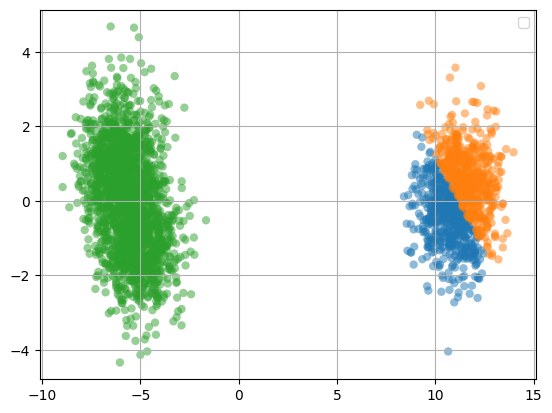

Blobs
1.1092238165870323
(4, 150)
Iris
1.2259818369606426
(64, 1797)
Digits
1.1189453962411249


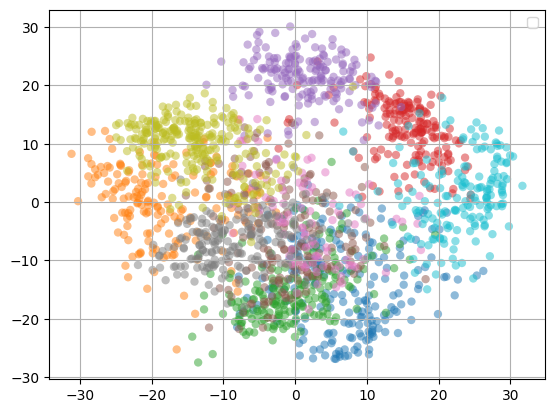

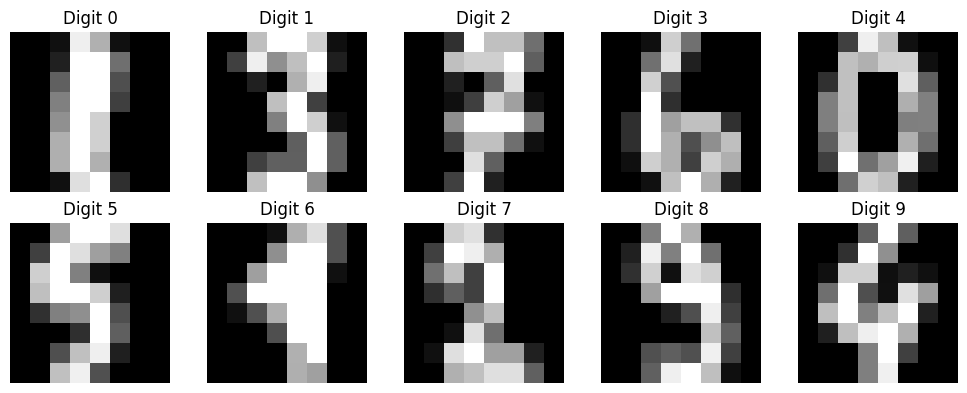

In [33]:

import numpy as np
import sklearn as sk
import sklearn.datasets as ds


def generate_data(num_samples, num_features, c, shuffle=True):

    dataset = ds.make_blobs(n_samples=num_samples, n_features=num_features, centers=c, shuffle=False)[0]

    dataset = dataset.T

    labels = np.zeros(num_samples)

    j = int(num_samples / c)

    for i in range(c):
        p = i * j
        q = (i + 1) * j
        print()
        labels[p:q] = i

    return dataset, labels


def verify_clusters(dataset, c, cluster_centers, membership_matrix, labels):

    ssd_actual = 0

    for i in range(c):
        # All points in class
        x1 = dataset[labels == i]
        # Mean of class
        m = np.mean(x1, axis=0)

        for pt in x1:
            ssd_actual += np.linalg.norm(pt - m)

    clm = np.argmax(membership_matrix, axis=0)
    ssd_clusters = 0

    for i in range(c):
        # Points clustered in a class
        x2 = dataset[clm == i]

        for pt in x2:
            ssd_clusters += np.linalg.norm(pt - cluster_centers[i])

    print(ssd_clusters / ssd_actual)


num_samples = 3000
num_features = 2
c = 3
fuzzifier = 1.2
error = 0.0001
maxiter = 1000

# np.random.seed(100)

dataset, labels = generate_data(num_samples, num_features, c, shuffle=False)

cluster_centers, initia_cluster_centers, membership_matrix, initial_membership_matrix, d, t = fcm(dataset, c, fuzzifier, error, maxiter)

plot(dataset.T, cluster_centers, membership_matrix, c)

print("Blobs")
verify_clusters(dataset.T, c, cluster_centers, membership_matrix, labels)

iris = ds.load_iris()

labels = iris.target_names
target = iris.target
iris = np.array(iris.data).T

c = 3

cluster_centers, initia_cluster_centers, membership_matrix, initial_membership_matrix, d, t = fcm(iris, c, fuzzifier, error, maxiter)
print(iris.shape)
iris = iris.T

print("Iris")

verify_clusters(iris, c, cluster_centers, membership_matrix, target)

############################################################################
digits = ds.load_digits()

labels = digits.target

digits = np.array(digits.data).T
print(digits.shape)
c = 10
cluster_centers, initia_cluster_centers, membership_matrix, initial_membership_matrix, d, t = pcm(digits, c, fuzzifier, error, maxiter)
print("Digits")
verify_clusters(digits.T, c, cluster_centers, membership_matrix, labels)
plot(digits.T, cluster_centers, membership_matrix, c)
cluster_centers.shape

image_array_reshaped = cluster_centers.reshape(-1, 8, 8)
# Plot each image
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    ax.imshow(image_array_reshaped[i], cmap='gray')
    ax.set_title(f'Digit {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()
############################################################################
# from keras.datasets import mnist
# (train_X, train_y), (test_X, test_y) = mnist.load_data()
# train_X = train_X.reshape(-1, 28*28)
# train_X = np.array(train_X).T
# c = 10
# cluster_centers, initia_cluster_centers, membership_matrix, initial_membership_matrix, d, t = pcm(train_X, c, fuzzifier, error, maxiter)
# plot(digits.T, cluster_centers, membership_matrix, c)
# print(cluster_centers.shape)